In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [8]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 100000.0)

(0.0, 100000.0)

In [86]:
k_space = range(-0.5, 0.5, length = 1000)
length(k_space)

1000

In [87]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)

int (generic function with 1 method)

In [88]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [89]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
        #  SA[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k, k, 0]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    """Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)"""
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: -0.5
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.5, 0.0]
Spectrum: [8.053522181046427e-5, -0.004909821715984384, -0.01979441374015985, -0.020360865020273178, -5.7354932063452715, -14.164451656622091]
Last point: [-0.8861475889400205, -3.091653910687762, 3.938407652213857, -1.3504370927547737, -8.615614332981712, 3.2773966435931965]
x_sum before truncate length: 1817953
x_sum after truncate length: 908978
>>>>>>>>>>>>>>>

Initial condition: [-0.8861475889400205, -3.091653910687762, 3.938407652213857, -1.3504370927547737, -8.615614332981712, 3.2773966435931965]
index: 2
k: -0.498998998998999
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.498998998998999, -0.498998998998999, 0.0]
Spectrum: [2.2750413285023138e-5, -0.004838634494561596, -0.020085399234343788, -0.02058441088959475, -5.727962422754796, -14.187174727899642]
Last point: [-0.49842660100309627, -1.1429272429956168, 3.519135911864175, -1.175520

index: 14
k: -0.486986986986987
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.486986986986987, -0.486986986986987, 0.0]
Spectrum: [1.0769810800297644e-5, -0.003970412743092676, -0.01536150993146253, -0.02608258547044044, -5.689963775171245, -14.278368204475163]
Last point: [-1.3817506490876352, -8.345160670816892, 4.005187808275777, -0.6469730245597962, -1.9221572348727614, 3.4566193653382946]
x_sum before truncate length: 1827809
x_sum after truncate length: 913906
>>>>>>>>>>>>>>>

Initial condition: [-1.3817506490876352, -8.345160670816892, 4.005187808275777, -0.6469730245597962, -1.9221572348727614, 3.4566193653382946]
index: 15
k: -0.48598598598598597
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48598598598598597, -0.48598598598598597, 0.0]
Spectrum: [8.799139139620385e-6, -0.003996619918302814, -0.007266288671901288, -0.030370212493371067, -5.698245365292784, -14.277963986546435]
Last point: [0.11886585225855055, 0.01196253181030913, 3.0954120361786246, -1.2032078

index: 27
k: -0.47397397397397395
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47397397397397395, -0.47397397397397395, 0.0]
Spectrum: [1.3545624896791642e-5, -0.0006465464299035999, -0.0007119342990668578, -0.056603636748944426, -5.899491288625278, -13.912031231594908]
Last point: [-1.1700523434261252, -5.796085974464973, 3.9136919236695595, -0.9025362813070844, -3.7669147617656056, 3.3261666544749517]
x_sum before truncate length: 1786494
x_sum after truncate length: 893248
>>>>>>>>>>>>>>>

Initial condition: [-1.1700523434261252, -5.796085974464973, 3.9136919236695595, -0.9025362813070844, -3.7669147617656056, 3.3261666544749517]
index: 28
k: -0.47297297297297297
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47297297297297297, -0.47297297297297297, 0.0]
Spectrum: [7.832618874885812e-6, -0.0006947003552641165, -0.0007614812455065602, -0.056939574671656855, -5.898600339971323, -13.911700267581757]
Last point: [-0.6526317860930932, -2.255531191703716, 3.100545085242291

index: 40
k: -0.46096096096096095
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46096096096096095, -0.46096096096096095, 0.0]
Spectrum: [1.776462590205537e-5, -0.001341357652907608, -0.0013626746814751716, -0.061400897433636796, -5.887552063299421, -13.902312601453568]
Last point: [0.2165458975367275, 0.418941810847655, 3.6576311717220076, -1.5379951007744115, -9.647450753933315, 3.5568548699553904]
x_sum before truncate length: 1780410
x_sum after truncate length: 890206
>>>>>>>>>>>>>>>

Initial condition: [0.2165458975367275, 0.418941810847655, 3.6576311717220076, -1.5379951007744115, -9.647450753933315, 3.5568548699553904]
index: 41
k: -0.45995995995996
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45995995995996, -0.45995995995996, 0.0]
Spectrum: [1.5699742341521248e-5, -0.0014061098432294424, -0.0014073499408053145, -0.061836674638020867, -5.8863359846334316, -13.901684816710661]
Last point: [-1.4685096814890806, -9.041135152718683, 3.574868355430559, -0.1522369536

>>>>>>>>>>>>>>>

Initial condition: [-0.8465242100462458, -2.9069259845626085, 3.805825783280239, -1.4307973529599265, -9.671983801615546, 3.3636036128400275]
index: 53
k: -0.44794794794794796
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44794794794794796, -0.44794794794794796, 0.0]
Spectrum: [1.8643236617827573e-5, -0.0019386912739324715, -0.0019819103979218616, -0.06795420412263753, -5.871798875528895, -13.89037967891378]
Last point: [-0.7041168005214037, -2.1403927880111424, 3.5877761962452484, -1.4075141624576673, -9.062345446774398, 3.6416349590779054]
x_sum before truncate length: 1773821
x_sum after truncate length: 886912
>>>>>>>>>>>>>>>

Initial condition: [-0.7041168005214037, -2.1403927880111424, 3.5877761962452484, -1.4075141624576673, -9.062345446774398, 3.6416349590779054]
index: 54
k: -0.4469469469469469
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4469469469469469, -0.4469469469469469, 0.0]
Spectrum: [4.017309706598668e-5, -0.0019779604884333515, -0.00

x_sum before truncate length: 1768420
x_sum after truncate length: 884211
>>>>>>>>>>>>>>>

Initial condition: [-0.9156806271928383, -3.263180303804679, 4.008887856432552, -0.8961697108315045, -3.9096977716305368, 3.107069234734869]
index: 66
k: -0.43493493493493496
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43493493493493496, -0.43493493493493496, 0.0]
Spectrum: [1.1452435009796416e-6, -0.0024969170957974515, -0.002512304395406203, -0.07782340575580944, -5.8509759474594, -13.877256944956473]
Last point: [0.895052648645046, 0.04048949556271987, 3.944103795776418, -1.4148077163690806, -8.19137308029884, 3.2173592539177003]
x_sum before truncate length: 1766239
x_sum after truncate length: 883121
>>>>>>>>>>>>>>>

Initial condition: [0.895052648645046, 0.04048949556271987, 3.944103795776418, -1.4148077163690806, -8.19137308029884, 3.2173592539177003]
index: 67
k: -0.4339339339339339
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4339339339339339, -0.4339339339339339, 0.0]

Last point: [-1.4269408411930442, -9.324671166103975, 3.6728758191584663, -0.8160968844680878, -2.8699060194187167, 3.596444129467771]
x_sum before truncate length: 1760059
x_sum after truncate length: 880031
>>>>>>>>>>>>>>>

Initial condition: [-1.4269408411930442, -9.324671166103975, 3.6728758191584663, -0.8160968844680878, -2.8699060194187167, 3.596444129467771]
index: 79
k: -0.4219219219219219
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4219219219219219, -0.4219219219219219, 0.0]
Spectrum: [4.973831435270471e-6, -0.002979252212122639, -0.003007715732252704, -0.09700028700271243, -5.819245846241743, -13.862450237441912]
Last point: [-0.8502646418396466, -3.3288870413262965, 3.360144271806888, -1.2169189817451993, -6.332718045991115, 3.9134918882361855]
x_sum before truncate length: 1757828
x_sum after truncate length: 878915
>>>>>>>>>>>>>>>

Initial condition: [-0.8502646418396466, -3.3288870413262965, 3.360144271806888, -1.2169189817451993, -6.332718045991115, 3.913491888

Spectrum: [-1.2877415608606819e-5, -0.003367112269644197, -0.0034057480143087995, -0.12791083851404708, -5.774954903052304, -13.84709608229983]
Last point: [-0.31945540699338715, -0.2204841547863969, 3.878123177361506, -1.244503225160157, -6.913607789106076, 3.250849490898449]
x_sum before truncate length: 1753247
x_sum after truncate length: 876625
>>>>>>>>>>>>>>>

Initial condition: [-0.31945540699338715, -0.2204841547863969, 3.878123177361506, -1.244503225160157, -6.913607789106076, 3.250849490898449]
index: 92
k: -0.4089089089089089
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4089089089089089, -0.4089089089089089, 0.0]
Spectrum: [8.110616620801779e-6, -0.0034186642050971377, -0.0034129732819455976, -0.11997599741784298, -5.781820526130437, -13.845713027078451]
Last point: [-1.4997891959297285, -10.654231157793829, 3.4384175877420757, -0.9441432163464832, -3.6513125040622203, 3.841010467096324]
x_sum before truncate length: 1750977
x_sum after truncate length: 875490
>>>>>

index: 104
k: -0.3968968968968969
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3968968968968969, -0.3968968968968969, 0.0]
Spectrum: [1.6504905816013776e-5, -0.003760690126368242, -0.003792176069380296, -0.08508217201754474, -5.8019725483695375, -13.829438494568066]
Last point: [-0.184807976059609, -0.039375831052997676, 3.6717816153434764, -1.454137225956851, -9.060193148924576, 3.567483488928672]
x_sum before truncate length: 1743403
x_sum after truncate length: 871703
>>>>>>>>>>>>>>>

Initial condition: [-0.184807976059609, -0.039375831052997676, 3.6717816153434764, -1.454137225956851, -9.060193148924576, 3.567483488928672]
index: 105
k: -0.3958958958958959
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3958958958958959, -0.3958958958958959, 0.0]
Spectrum: [1.7885018778028244e-5, -0.003781481122150548, -0.003801866738885117, -0.08364723601273269, -5.802122850303145, -13.827965945241196]
Last point: [-0.9695705480357014, -4.073311122909356, 3.618990875396957, -1.45820

index: 117
k: -0.3838838838838839
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3838838838838839, -0.3838838838838839, 0.0]
Spectrum: [3.3206605537777594e-6, -0.004053740286854621, -0.004120053293040923, -0.0706337431766353, -5.798794932877234, -13.810204754209797]
Last point: [-0.753038215356976, -2.823957309096202, 3.1543856690126013, -0.9469348045592136, -3.489626980555107, 4.041601542463225]
x_sum before truncate length: 1739690
x_sum after truncate length: 869846
>>>>>>>>>>>>>>>

Initial condition: [-0.753038215356976, -2.823957309096202, 3.1543856690126013, -0.9469348045592136, -3.489626980555107, 4.041601542463225]
index: 118
k: -0.38288288288288286
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38288288288288286, -0.38288288288288286, 0.0]
Spectrum: [6.081394781334391e-6, -0.004109699113356307, -0.004100936536020692, -0.06985512177971784, -5.797977348177443, -13.808842747189892]
Last point: [-1.0560170065543684, -5.300008084456943, 3.1480693499399273, -0.94855969

>>>>>>>>>>>>>>>

Initial condition: [-1.4303194933072993, -9.644987799313817, 3.386777233109343, -0.8955988671109035, -3.235756997278289, 3.8601388580011866]
index: 130
k: -0.3708708708708709
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3708708708708709, -0.3708708708708709, 0.0]
Spectrum: [2.389161515988081e-5, -0.004355394460209708, -0.004385875109302563, -0.06167062134008331, -5.788351583948363, -13.789360446923935]
Last point: [-0.9487219436621415, -3.4724131117918002, 4.083940554076321, -1.1028922947450548, -5.761315016353414, 3.1623296717811598]
x_sum before truncate length: 1729670
x_sum after truncate length: 864836
>>>>>>>>>>>>>>>

Initial condition: [-0.9487219436621415, -3.4724131117918002, 4.083940554076321, -1.1028922947450548, -5.761315016353414, 3.1623296717811598]
index: 131
k: -0.36986986986986986
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36986986986986986, -0.36986986986986986, 0.0]
Spectrum: [3.5496785497180484e-5, -0.004362819700531045, -0.00439

x_sum before truncate length: 1720967
x_sum after truncate length: 860485
>>>>>>>>>>>>>>>

Initial condition: [-1.2952230030242786, -6.117603021589132, 4.006453019429083, 0.5158978642916695, -6.569312313737394, 3.400869962279596]
index: 143
k: -0.35785785785785784
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35785785785785784, -0.35785785785785784, 0.0]
Spectrum: [2.212802915048839e-5, -0.004622409785442865, -0.004624381855938367, -0.05511916114518345, -5.774049635707298, -13.767544928784622]
Last point: [-0.8628643851070158, -2.9743376301796958, 3.8683129415060766, -1.3900817389520315, -9.08787137250924, 3.3609653393991654]
x_sum before truncate length: 1721018
x_sum after truncate length: 860510
>>>>>>>>>>>>>>>

Initial condition: [-0.8628643851070158, -2.9743376301796958, 3.8683129415060766, -1.3900817389520315, -9.08787137250924, 3.3609653393991654]
index: 144
k: -0.35685685685685686
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35685685685685686, -0.35685685685685

Last point: [-1.4816869351659765, -10.362577336642453, 3.4486850578751516, -0.9458097254893721, -3.619330572246856, 3.8924985795805083]
x_sum before truncate length: 1710901
x_sum after truncate length: 855452
>>>>>>>>>>>>>>>

Initial condition: [-1.4816869351659765, -10.362577336642453, 3.4486850578751516, -0.9458097254893721, -3.619330572246856, 3.8924985795805083]
index: 156
k: -0.34484484484484484
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34484484484484484, -0.34484484484484484, 0.0]
Spectrum: [1.6010235265978703e-5, -0.00481344366186952, -0.004819787854331856, -0.049977789321671275, -5.75683342355352, -13.743400710914228]
Last point: [-0.9273421154541841, -3.6733345540228703, 3.6587860031628927, -1.4587472891351183, -9.728964427789748, 3.749873700775766]
x_sum before truncate length: 1708295
x_sum after truncate length: 854149
>>>>>>>>>>>>>>>

Initial condition: [-0.9273421154541841, -3.6733345540228703, 3.6587860031628927, -1.4587472891351183, -9.728964427789748, 3.74

Spectrum: [6.43611194710223e-6, -0.004977169994339645, -0.004991944790047951, -0.046090498926532206, -5.738653014234204, -13.719671280761602]
Last point: [-1.1674192450979186, -5.687433366445166, 3.2491596532582636, -0.12775496079934207, 0.2716279335061459, 3.9563919090702293]
x_sum before truncate length: 1699758
x_sum after truncate length: 849880
>>>>>>>>>>>>>>>

Initial condition: [-1.1674192450979186, -5.687433366445166, 3.2491596532582636, -0.12775496079934207, 0.2716279335061459, 3.9563919090702293]
index: 169
k: -0.33183183183183185
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33183183183183185, -0.33183183183183185, 0.0]
Spectrum: [1.2182953741681147e-5, -0.004975822324489356, -0.005003278199852884, -0.04581204546376858, -5.737160449391007, -13.71773291613195]
Last point: [-0.5201871705900073, -0.9120914645299152, 3.9147649456610765, -1.1627638051843097, -6.254682023048241, 3.2677702954275656]
x_sum before truncate length: 1699020
x_sum after truncate length: 849511
>

index: 181
k: -0.31981981981981983
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31981981981981983, -0.31981981981981983, 0.0]
Spectrum: [3.0812578246928126e-5, -0.005152858587139141, -0.005201362721451727, -0.04252533665472731, -5.716484108668048, -13.69254817959272]
Last point: [-0.9474809596009945, -4.032909107736825, 3.447102485970376, -1.2464540052536934, -6.592870873740968, 4.016420789383385]
x_sum before truncate length: 1687870
x_sum after truncate length: 843936
>>>>>>>>>>>>>>>

Initial condition: [-0.9474809596009945, -4.032909107736825, 3.447102485970376, -1.2464540052536934, -6.592870873740968, 4.016420789383385]
index: 182
k: -0.3188188188188188
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3188188188188188, -0.3188188188188188, 0.0]
Spectrum: [1.9137785249458993e-5, -0.005169517834567493, -0.005201477134453268, -0.04226962771369924, -5.714704228827461, -13.690656504045291]
Last point: [-0.680036475035566, -2.1074286011051084, 3.4598365921287364, -1.2785985

index: 194
k: -0.30680680680680683
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.30680680680680683, -0.30680680680680683, 0.0]
Spectrum: [1.634050978475882e-5, -0.005375515580331607, -0.00540889758532774, -0.039476303280915934, -5.689893392160822, -13.666129420511284]
Last point: [-0.2373275668154906, -0.4590319042394173, 3.2717951350579995, -1.040361445446644, -3.9139633890785115, 4.1052027934776785]
x_sum before truncate length: 1675256
x_sum after truncate length: 837629
>>>>>>>>>>>>>>>

Initial condition: [-0.2373275668154906, -0.4590319042394173, 3.2717951350579995, -1.040361445446644, -3.9139633890785115, 4.1052027934776785]
index: 195
k: -0.3058058058058058
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3058058058058058, -0.3058058058058058, 0.0]
Spectrum: [1.4921133625324168e-5, -0.0053850128246396975, -0.005428968067840681, -0.039245910641938, -5.687635615312909, -13.663860534229524]
Last point: [1.590349784911816, -1.733043757920364, 3.363665212195341, -1.21322

index: 207
k: -0.2937937937937938
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2937937937937938, -0.2937937937937938, 0.0]
Spectrum: [1.6209630649841367e-5, -0.005636244882085902, -0.005689135458627449, -0.03681288510665177, -5.6568560069592, -13.640758784986067]
Last point: [-0.9712714467059024, -4.011907572468592, 3.7167312572204865, -1.4690561065187546, -9.808655496043828, 3.8322175532901936]
x_sum before truncate length: 1662255
x_sum after truncate length: 831129
>>>>>>>>>>>>>>>

Initial condition: [-0.9712714467059024, -4.011907572468592, 3.7167312572204865, -1.4690561065187546, -9.808655496043828, 3.8322175532901936]
index: 208
k: -0.2927927927927928
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2927927927927928, -0.2927927927927928, 0.0]
Spectrum: [2.4491265974215027e-5, -0.005655379831159095, -0.005705275347830381, -0.036604408208247896, -5.6544153828975565, -13.639457967287118]
Last point: [-1.2683425388720084, -5.915566208768803, 4.085398954722761, 0.8969322

index: 220
k: -0.2807807807807808
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2807807807807808, -0.2807807807807808, 0.0]
Spectrum: [2.38295951128614e-5, -0.006048552167264467, -0.006091387975576974, -0.03443030234341297, -5.620760790458377, -13.614555052299087]
Last point: [-0.7902127152368219, -2.3934189805119734, 3.9336987394408083, -1.2531033404015604, -7.315029935546073, 3.3205636732561428]
x_sum before truncate length: 1648966
x_sum after truncate length: 824484
>>>>>>>>>>>>>>>

Initial condition: [-0.7902127152368219, -2.3934189805119734, 3.9336987394408083, -1.2531033404015604, -7.315029935546073, 3.3205636732561428]
index: 221
k: -0.2797797797797798
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2797797797797798, -0.2797797797797798, 0.0]
Spectrum: [2.463982498739337e-5, -0.006098726586593207, -0.006106094442208594, -0.03426598091580229, -5.617876744302729, -13.612213501656495]
Last point: [-0.9561419687051579, -3.4572267838290616, 4.164671063453131, -0.710354

index: 233
k: -0.2677677677677678
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2677677677677678, -0.2677677677677678, 0.0]
Spectrum: [3.0814845712667005e-5, -0.006695795771137781, -0.006723931535179575, -0.032220353217715096, -5.590732268107371, -13.577607947228627]
Last point: [0.24199947926643703, 0.5209136838062399, 3.830810082367981, -1.5021203797903695, -9.675484933927319, 3.594858092001662]
x_sum before truncate length: 1634143
x_sum after truncate length: 817073
>>>>>>>>>>>>>>>

Initial condition: [0.24199947926643703, 0.5209136838062399, 3.830810082367981, -1.5021203797903695, -9.675484933927319, 3.594858092001662]
index: 234
k: -0.26676676676676675
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26676676676676675, -0.26676676676676675, 0.0]
Spectrum: [1.2010499001264417e-5, -0.006769531164910888, -0.0067630879570376575, -0.03205411989551882, -5.58892077229474, -13.574031999355519]
Last point: [1.507950584232562, -4.630394497502553, 4.159422593428841, -1.00371635

>>>>>>>>>>>>>>>

Initial condition: [-0.9275214620107176, -3.3897460095980483, 3.977750292830549, -1.4206456189962886, -9.447851944037263, 3.446944242543675]
index: 246
k: -0.25475475475475473
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25475475475475473, -0.25475475475475473, 0.0]
Spectrum: [-2.7494549976580987e-6, -0.007811928957787526, -0.007867338934137567, -0.029706403012344014, -5.581671631697212, -13.51399595878793]
Last point: [-1.1667345718242508, -4.791848649127271, 4.165745127807895, 1.5612945845732222, -1.6413561185058345, 3.4284186392672416]
x_sum before truncate length: 1621332
x_sum after truncate length: 810667
>>>>>>>>>>>>>>>

Initial condition: [-1.1667345718242508, -4.791848649127271, 4.165745127807895, 1.5612945845732222, -1.6413561185058345, 3.4284186392672416]
index: 247
k: -0.25375375375375375
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25375375375375375, -0.25375375375375375, 0.0]
Spectrum: [2.4929111067863245e-5, -0.007952365028339512, -0.00

x_sum before truncate length: 1610635
x_sum after truncate length: 805319
>>>>>>>>>>>>>>>

Initial condition: [-0.885124671299692, -3.0504105332000293, 3.9758548891617007, -1.3204497578942294, -8.121333398645644, 3.378367226882109]
index: 259
k: -0.24174174174174173
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24174174174174173, -0.24174174174174173, 0.0]
Spectrum: [1.8406970329140283e-5, -0.010688129251722136, -0.010712129981335451, -0.02205589906462523, -5.62538522597814, -13.393857098050121]
Last point: [-0.8153595958784574, -2.5367647575198853, 3.9695690800340144, -1.2091388684997155, -6.782446240443912, 3.3273309647818134]
x_sum before truncate length: 1611897
x_sum after truncate length: 805950
>>>>>>>>>>>>>>>

Initial condition: [-0.8153595958784574, -2.5367647575198853, 3.9695690800340144, -1.2091388684997155, -6.782446240443912, 3.3273309647818134]
index: 260
k: -0.24074074074074073
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24074074074074073, -0.2407407407

Last point: [-0.9978444812719358, -3.878495644514815, 4.112059796963656, -1.328629758319629, -8.174474891055741, 3.438580706908612]
x_sum before truncate length: 1482063
x_sum after truncate length: 741033
>>>>>>>>>>>>>>>

Initial condition: [-0.9978444812719358, -3.878495644514815, 4.112059796963656, -1.328629758319629, -8.174474891055741, 3.438580706908612]
index: 272
k: -0.22872872872872874
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22872872872872874, -0.22872872872872874, 0.0]
Spectrum: [0.014090214179540131, 0.0006117619801754518, -0.00030243024828387845, -0.026296572156172815, -6.260613795104687, -12.077508885065056]
Last point: [-0.6009598409305013, -1.056128092677977, 3.939120925019667, -0.23720294278732484, 0.04907243683389713, 3.937909949289462]
x_sum before truncate length: 1479197
x_sum after truncate length: 739600
>>>>>>>>>>>>>>>

Initial condition: [-0.6009598409305013, -1.056128092677977, 3.939120925019667, -0.23720294278732484, 0.04907243683389713, 3.9379099

Spectrum: [5.5768353591624674e-6, -0.006506685194845235, -0.006571166453089668, -0.012074717947391032, -5.963825215317414, -12.766056236493494]
Last point: [-1.2374718767142845, -6.6434725763351725, 3.403112899408749, -0.1735950311669121, 0.23519069124163786, 4.023402407931641]
x_sum before truncate length: 1559357
x_sum after truncate length: 779680
>>>>>>>>>>>>>>>

Initial condition: [-1.2374718767142845, -6.6434725763351725, 3.403112899408749, -0.1735950311669121, 0.23519069124163786, 4.023402407931641]
index: 285
k: -0.2157157157157157
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2157157157157157, -0.2157157157157157, 0.0]
Spectrum: [3.387179697270491e-5, -0.0064028037774762495, -0.006392878374980926, -0.011994691611276568, -5.958197682913284, -12.764603734547338]
Last point: [-1.364134435219252, -8.564917448020248, 3.5331213558152395, -0.8145484929115331, -2.5414528384928188, 3.9577282731823598]
x_sum before truncate length: 1556917
x_sum after truncate length: 778460
>>>

index: 297
k: -0.2037037037037037
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2037037037037037, -0.2037037037037037, 0.0]
Spectrum: [0.014956909169689742, 0.0023735129735245873, -0.0003182271031034513, -0.029987721454632094, -6.3446740395037455, -11.81543376490392]
Last point: [-1.2402257139342825, -6.64085547834173, 3.8830500453663492, -0.9214593313177869, -3.5177195249019992, 3.7784267726580887]
x_sum before truncate length: 1431797
x_sum after truncate length: 715900
>>>>>>>>>>>>>>>

Initial condition: [-1.2402257139342825, -6.64085547834173, 3.8830500453663492, -0.9214593313177869, -3.5177195249019992, 3.7784267726580887]
index: 298
k: -0.20270270270270271
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.20270270270270271, -0.20270270270270271, 0.0]
Spectrum: [0.015108219452587855, 0.0029241045396390716, 6.012991683283664e-6, -0.029979063475529626, -6.364888964864991, -11.773819255154987]
Last point: [-1.0145363303010049, -4.236316569320512, 3.8846095669627503, -0.94

index: 310
k: -0.1906906906906907
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1906906906906907, -0.1906906906906907, 0.0]
Spectrum: [0.014987633041251995, 0.00489734595477088, -2.2573358698567934e-5, -0.028824378582417553, -6.413441468630217, -11.634255280295374]
Last point: [-1.1756777502680678, -5.1608311032730745, 4.073835470920476, 0.5020738616838654, 0.30266058491987413, 3.4564561331718027]
x_sum before truncate length: 1405312
x_sum after truncate length: 702657
>>>>>>>>>>>>>>>

Initial condition: [-1.1756777502680678, -5.1608311032730745, 4.073835470920476, 0.5020738616838654, 0.30266058491987413, 3.4564561331718027]
index: 311
k: -0.1896896896896897
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1896896896896897, -0.1896896896896897, 0.0]
Spectrum: [0.015490289314172222, 0.004768450831436811, 1.0580499661320506e-6, -0.02909255790681398, -6.424459874625409, -11.614559554012263]
Last point: [-1.0370770144903867, -4.422290502219515, 3.9080696232171137, -0.69840295

index: 323
k: -0.17767767767767767
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17767767767767767, -0.17767767767767767, 0.0]
Spectrum: [0.01339205789068538, 0.003231991735001225, 6.660378410527482e-6, -0.0256562122937993, -6.393547418069704, -11.600043346074232]
Last point: [-0.028396577819955828, 0.30634144162479937, 3.592989733133793, -0.20046747837927106, 0.4081774757265915, 4.069786773459783]
x_sum before truncate length: 1391846
x_sum after truncate length: 695924
>>>>>>>>>>>>>>>

Initial condition: [-0.028396577819955828, 0.30634144162479937, 3.592989733133793, -0.20046747837927106, 0.4081774757265915, 4.069786773459783]
index: 324
k: -0.17667667667667666
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17667667667667666, -0.17667667667667666, 0.0]
Spectrum: [0.01330060609391721, 0.0033713468694298093, -6.936018645723022e-5, -0.025761096067109187, -6.384086461631243, -11.608851895291012]
Last point: [-0.9613559916029852, -3.961715725314548, 3.6601510015172622, -1.1

>>>>>>>>>>>>>>>

Initial condition: [-0.3315922514623682, -0.3892914691764039, 3.7051047755546946, -1.2979840074861437, -7.100083305848101, 4.017230537015473]
index: 336
k: -0.16466466466466467
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16466466466466467, -0.16466466466466467, 0.0]
Spectrum: [0.014885695899018054, 0.005442165568003321, -2.7365172548397957e-5, -0.026984098338054922, -6.429475986832847, -11.509720060494654]
Last point: [-0.9490697005041295, -3.494715199056997, 4.062412108514932, -1.0659231840133827, -5.099733467624042, 3.476539641512736]
x_sum before truncate length: 1377494
x_sum after truncate length: 688748
>>>>>>>>>>>>>>>

Initial condition: [-0.9490697005041295, -3.494715199056997, 4.062412108514932, -1.0659231840133827, -5.099733467624042, 3.476539641512736]
index: 337
k: -0.16366366366366367
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16366366366366367, -0.16366366366366367, 0.0]
Spectrum: [0.014611344692905585, 0.006145763317125806, 1.4631042

x_sum before truncate length: 1372741
x_sum after truncate length: 686372
>>>>>>>>>>>>>>>

Initial condition: [-0.819653781017111, -2.5556381396647136, 3.982803124257525, -1.2202891593755634, -6.454910378855195, 3.8256369336043834]
index: 349
k: -0.15165165165165165
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15165165165165165, -0.15165165165165165, 0.0]
Spectrum: [0.014133225640931424, 0.00466283802379689, -1.8163552127241566e-5, -0.024041851087403518, -6.431309520939644, -11.476643666222957]
Last point: [-0.7524568173807105, -2.231318344829396, 3.8318194027825463, -1.1034728887034673, -5.24502456725624, 3.732415602888772]
x_sum before truncate length: 1373828
x_sum after truncate length: 686915
>>>>>>>>>>>>>>>

Initial condition: [-0.7524568173807105, -2.231318344829396, 3.8318194027825463, -1.1034728887034673, -5.24502456725624, 3.732415602888772]
index: 350
k: -0.15065065065065064
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15065065065065064, -0.1506506506506506

Last point: [-1.0261639534617946, -4.29841622382586, 3.868724344670735, -0.39865243116923677, -0.4649248889343756, 3.884289444056247]
x_sum before truncate length: 1366346
x_sum after truncate length: 683174
>>>>>>>>>>>>>>>

Initial condition: [-1.0261639534617946, -4.29841622382586, 3.868724344670735, -0.39865243116923677, -0.4649248889343756, 3.884289444056247]
index: 362
k: -0.13863863863863865
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13863863863863865, -0.13863863863863865, 0.0]
Spectrum: [0.0116777904382645, 0.004033091166612563, -1.6556714214305924e-5, -0.020151441044290418, -6.385923159902381, -11.552298453239075]
Last point: [-0.8485895016645614, -3.1884407572713247, 3.4881323491260763, -0.5525588564758773, -0.9757564552127375, 4.012677507723361]
x_sum before truncate length: 1367343
x_sum after truncate length: 683673
>>>>>>>>>>>>>>>

Initial condition: [-0.8485895016645614, -3.1884407572713247, 3.4881323491260763, -0.5525588564758773, -0.9757564552127375, 4.01267

Spectrum: [0.011015382158114538, 0.003941810159589195, -1.2950031770855115e-5, -0.017503665751942534, -6.410454623185447, -11.48123892523972]
Last point: [-1.119735026329678, -5.527004491918254, 3.605930926238129, -0.6460438816058469, -1.5058983402724733, 3.940019819084075]
x_sum before truncate length: 1353318
x_sum after truncate length: 676660
>>>>>>>>>>>>>>>

Initial condition: [-1.119735026329678, -5.527004491918254, 3.605930926238129, -0.6460438816058469, -1.5058983402724733, 3.940019819084075]
index: 375
k: -0.12562562562562563
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12562562562562563, -0.12562562562562563, 0.0]
Spectrum: [0.01179632244802509, 0.004270479867992836, -3.9327767789783186e-5, -0.01666113937292234, -6.426787381753276, -11.435254799364687]
Last point: [-1.148772625520712, -5.522554817087743, 3.9513483867670907, -0.6473640758764999, -1.7415146821101763, 3.671215581922548]
x_sum before truncate length: 1355135
x_sum after truncate length: 677569
>>>>>>>>>>

index: 387
k: -0.11361361361361362
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11361361361361362, -0.11361361361361362, 0.0]
Spectrum: [0.011391179812509067, 0.0038848651984740943, -1.4626985451398452e-5, -0.014669784248789399, -6.443282901611808, -11.375417401780526]
Last point: [-0.8341017918193372, -2.7861911681344833, 3.8390706134563595, -1.2122465022299795, -6.1804254685079405, 4.0212788718380175]
x_sum before truncate length: 1338279
x_sum after truncate length: 669141
>>>>>>>>>>>>>>>

Initial condition: [-0.8341017918193372, -2.7861911681344833, 3.8390706134563595, -1.2122465022299795, -6.1804254685079405, 4.0212788718380175]
index: 388
k: -0.11261261261261261
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11261261261261261, -0.11261261261261261, 0.0]
Spectrum: [0.011233051706217065, 0.003509334661188177, -4.190682408469187e-5, -0.014518552307128459, -6.424304109498223, -11.410084070728184]
Last point: [-0.8674527366626238, -2.9015498397321666, 3.987573001295414

>>>>>>>>>>>>>>>

Initial condition: [-0.8833230420793438, -3.0783320924201774, 3.928535590708586, -1.1357633168668333, -5.556746653331705, 3.766480299414117]
index: 400
k: -0.1006006006006006
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1006006006006006, -0.1006006006006006, 0.0]
Spectrum: [0.008356020143098363, 0.0024768356121695, -3.8026168188484825e-5, -0.013609704316420942, -6.352559038956659, -11.517867851021236]
Last point: [-0.9770757102535924, -3.880503060270118, 3.62023170517086, 0.10124043620711341, 0.5821488734021835, 4.039700125521228]
x_sum before truncate length: 1343351
x_sum after truncate length: 671677
>>>>>>>>>>>>>>>

Initial condition: [-0.9770757102535924, -3.880503060270118, 3.62023170517086, 0.10124043620711341, 0.5821488734021835, 4.039700125521228]
index: 401
k: -0.0995995995995996
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.0995995995995996, -0.0995995995995996, 0.0]
Spectrum: [0.00743205603275784, 0.0028813774184022166, -1.507042598118898e-

x_sum before truncate length: 1338811
x_sum after truncate length: 669407
>>>>>>>>>>>>>>>

Initial condition: [-0.24589783913965949, -0.04751053832455121, 3.8495125646977018, -1.1514403133365807, -5.48545346138314, 3.904223015299258]
index: 413
k: -0.08758758758758758
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08758758758758758, -0.08758758758758758, 0.0]
Spectrum: [0.005636127566192797, 0.0012705509689336333, -2.4397609961286066e-6, -0.014298378198281857, -6.267679905705741, -11.619397421968863]
Last point: [-0.04877285713026522, 0.46128002807490104, 4.066034534123538, -1.0469407150023997, -4.694661451703581, 3.4951264963482225]
x_sum before truncate length: 1338302
x_sum after truncate length: 669152
>>>>>>>>>>>>>>>

Initial condition: [-0.04877285713026522, 0.46128002807490104, 4.066034534123538, -1.0469407150023997, -4.694661451703581, 3.4951264963482225]
index: 414
k: -0.08658658658658659
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08658658658658659, -0.086586

Last point: [-0.914767713470023, -3.3017899108035613, 3.95902476345163, -1.326577734995603, -7.831801446133824, 3.7776566054890997]
x_sum before truncate length: 1331535
x_sum after truncate length: 665769
>>>>>>>>>>>>>>>

Initial condition: [-0.914767713470023, -3.3017899108035613, 3.95902476345163, -1.326577734995603, -7.831801446133824, 3.7776566054890997]
index: 426
k: -0.07457457457457457
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07457457457457457, -0.07457457457457457, 0.0]
Spectrum: [0.0029910238910272296, 0.0011072655597041652, -1.5173502725523333e-5, -0.01345636541603442, -6.152526005441714, -11.747576247613253]
Last point: [-1.3128163102270176, -7.532137219312887, 3.9054887550093595, -0.9459386538883161, -3.462171670681677, 4.069200562931874]
x_sum before truncate length: 1331074
x_sum after truncate length: 665538
>>>>>>>>>>>>>>>

Initial condition: [-1.3128163102270176, -7.532137219312887, 3.9054887550093595, -0.9459386538883161, -3.462171670681677, 4.0692005629

Spectrum: [1.5057589524655231e-5, 1.3578576601990502e-5, -0.0033461998602362037, -0.014153764381819941, -6.117036183620885, -11.73240608185963]
Last point: [1.4899663921843471, -4.770043562136473, 4.146567268295773, -1.0031918171818472, -4.264443838016955, 3.550364091279307]
x_sum before truncate length: 1316180
x_sum after truncate length: 658091
>>>>>>>>>>>>>>>

Initial condition: [1.4899663921843471, -4.770043562136473, 4.146567268295773, -1.0031918171818472, -4.264443838016955, 3.550364091279307]
index: 439
k: -0.06156156156156156
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06156156156156156, -0.06156156156156156, 0.0]
Spectrum: [1.6413368978087342e-5, 1.895474130721613e-5, -0.005017497454772561, -0.013117063754931116, -6.112705293479414, -11.732745837042623]
Last point: [-0.9366631035255849, -3.689387281176295, 3.727945994744423, -1.1955928198370207, -5.999048648521019, 4.009416324274635]
x_sum before truncate length: 1314859
x_sum after truncate length: 657431
>>>>>>>>>

index: 451
k: -0.04954954954954955
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04954954954954955, -0.04954954954954955, 0.0]
Spectrum: [3.314584975334422e-5, 1.9586653815245432e-5, -0.0031141478172056407, -0.01020793540596491, -6.062751637193863, -11.75008945636053]
Last point: [-0.7900116123905332, -2.537767785622837, 3.767082600010157, -1.1681098997848167, -5.619989345815101, 4.083245251411915]
x_sum before truncate length: 1296755
x_sum after truncate length: 648379
>>>>>>>>>>>>>>>

Initial condition: [-0.7900116123905332, -2.537767785622837, 3.767082600010157, -1.1681098997848167, -5.619989345815101, 4.083245251411915]
index: 452
k: -0.04854854854854855
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04854854854854855, -0.04854854854854855, 0.0]
Spectrum: [3.8303536014154654e-5, 2.922076487191401e-5, -0.002582079471146656, -0.00982169225243155, -6.059314658904376, -11.75239735181525]
Last point: [-1.1241850159850357, -5.158575648925448, 4.067049916128853, -0.9159538

>>>>>>>>>>>>>>>

Initial condition: [-1.12273898910489, -5.560109964724701, 3.6086335663626024, -0.6143041180275342, -1.2926473577455726, 3.9938370009355797]
index: 464
k: -0.03653653653653654
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03653653653653654, -0.03653653653653654, 0.0]
Spectrum: [-1.285488746603179e-5, -0.0008073393019968499, -0.0008323644098682895, -0.006934801087527171, -6.0380505792379315, -11.729214927376246]
Last point: [-1.1789099404066832, -5.783807429029654, 4.036398540328199, -0.7344547801826566, -2.1482925913166326, 3.795206249573023]
x_sum before truncate length: 1273335
x_sum after truncate length: 636669
>>>>>>>>>>>>>>>

Initial condition: [-1.1789099404066832, -5.783807429029654, 4.036398540328199, -0.7344547801826566, -2.1482925913166326, 3.795206249573023]
index: 465
k: -0.03553553553553553
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03553553553553553, -0.03553553553553553, 0.0]
Spectrum: [1.2037607779414086e-5, -0.0009920322464170971, -

Last point: [-0.9032218080386726, -3.173417872624076, 3.9985053926669343, -1.24457245709123, -6.810273381808098, 3.7573878659868423]
x_sum before truncate length: 1251137
x_sum after truncate length: 625570
>>>>>>>>>>>>>>>

Initial condition: [-0.9032218080386726, -3.173417872624076, 3.9985053926669343, -1.24457245709123, -6.810273381808098, 3.7573878659868423]
index: 477
k: -0.023523523523523524
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.023523523523523524, -0.023523523523523524, 0.0]
Spectrum: [1.5906659310293026e-5, -0.0039038770738317307, -0.003943186914832091, -0.004948247557954839, -6.063955640017879, -11.617073609760071]
Last point: [-0.6253196945419981, -1.3459380905291154, 3.9984220797416334, -1.1087084497101078, -5.407839018921567, 3.615042516487127]
x_sum before truncate length: 1247330
x_sum after truncate length: 623666
>>>>>>>>>>>>>>>

Initial condition: [-0.6253196945419981, -1.3459380905291154, 3.9984220797416334, -1.1087084497101078, -5.407839018921567, 3.61

Spectrum: [1.4310050581773079e-5, -0.002842816635519996, -0.010590978260960768, -0.010605238865047674, -6.114464422717774, -11.46401217261074]
Last point: [-1.2387595591893819, -6.591569879937468, 3.9179836791599136, -0.9457942210100875, -3.4718857359221422, 4.057014102108442]
x_sum before truncate length: 1222111
x_sum after truncate length: 611057
>>>>>>>>>>>>>>>

Initial condition: [-1.2387595591893819, -6.591569879937468, 3.9179836791599136, -0.9457942210100875, -3.4718857359221422, 4.057014102108442]
index: 490
k: -0.010510510510510511
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.010510510510510511, -0.010510510510510511, 0.0]
Spectrum: [2.882151361632757e-5, -0.0026671066173596086, -0.01164631928950282, -0.0116317242515327, -6.120456551146396, -11.447093874551278]
Last point: [-0.6668313678912577, -1.716574599297709, 3.8278746347079107, -1.1611831377309803, -5.566789266983094, 4.05774623268755]
x_sum before truncate length: 1217489
x_sum after truncate length: 608746
>>>

index: 502
k: 0.0015015015015015015
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0015015015015015015, 0.0015015015015015015, 0.0]
Spectrum: [2.5347152180273523e-5, -0.003144617754114744, -0.006631649448012735, -0.008598659014979674, -6.465334217922625, -10.96595700639801]
Last point: [-0.8491124668811442, -2.7628930486400223, 3.9907373455339257, -1.2000220566993949, -6.295336031062242, 3.7433201482743463]
x_sum before truncate length: 1174165
x_sum after truncate length: 587084
>>>>>>>>>>>>>>>

Initial condition: [-0.8491124668811442, -2.7628930486400223, 3.9907373455339257, -1.2000220566993949, -6.295336031062242, 3.7433201482743463]
index: 503
k: 0.0025025025025025025
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0025025025025025025, 0.0025025025025025025, 0.0]
Spectrum: [6.158819273956986e-5, -0.002676200531258938, -0.002683420464277003, -0.004166419272209739, -6.461862678881586, -10.951495734685807]
Last point: [-0.6911090960919692, -1.7138940452204017, 3.99416500397

x_sum after truncate length: 610671
>>>>>>>>>>>>>>>

Initial condition: [-0.4178088822019374, -0.40935214902087247, 4.039151684382158, -0.9026604992063376, -3.167655461942482, 4.005368924318644]
index: 515
k: 0.014514514514514515
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.014514514514514515, 0.014514514514514515, 0.0]
Spectrum: [3.183990339056293e-5, -0.012254156828554906, -0.012319619830208052, -0.03559422562879563, -7.224242894253621, -10.238490189458258]
Last point: [0.8776009077972243, -5.463376216299274, 4.061163014147221, -0.8734192819204185, -3.1225517159026435, 3.8338982912752657]
x_sum before truncate length: 1223119
x_sum after truncate length: 611561
>>>>>>>>>>>>>>>

Initial condition: [0.8776009077972243, -5.463376216299274, 4.061163014147221, -0.8734192819204185, -3.1225517159026435, 3.8338982912752657]
index: 516
k: 0.015515515515515516
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.015515515515515516, 0.015515515515515516, 0.0]
Spectrum: [2.53599911673446

x_sum before truncate length: 1242039
x_sum after truncate length: 621021
>>>>>>>>>>>>>>>

Initial condition: [-1.0406806230667753, -4.292939640778896, 4.175278925339552, 1.4214593629074281, -1.6224081723963364, 4.1688321238815]
index: 528
k: 0.027527527527527528
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.027527527527527528, 0.027527527527527528, 0.0]
Spectrum: [3.50368832806677e-5, -0.011188163899291587, -0.024319967507611256, -0.02436348276571134, -7.201592022971077, -10.305846215080454]
Last point: [-1.2094384838321928, -6.181761042803964, 3.985282943241337, -1.091171256210369, -4.753725298568322, 4.135655742848221]
x_sum before truncate length: 1242595
x_sum after truncate length: 621299
>>>>>>>>>>>>>>>

Initial condition: [-1.2094384838321928, -6.181761042803964, 3.985282943241337, -1.091171256210369, -4.753725298568322, 4.135655742848221]
index: 529
k: 0.028528528528528527
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.028528528528528527, 0.028528528528528527, 0.0

x_sum before truncate length: 1253830
x_sum after truncate length: 626916
>>>>>>>>>>>>>>>

Initial condition: [-0.9442929740055057, -3.28108903935509, 4.258274730682397, -0.6344330806901309, -1.3852374029679673, 4.008946717177408]
index: 541
k: 0.04054054054054054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04054054054054054, 0.04054054054054054, 0.0]
Spectrum: [3.2075285146482104e-5, -0.0035345305848222086, -0.015803990358192747, -0.025307743847309057, -7.270470226496126, -10.294097959589935]
Last point: [-0.9170160643126306, -3.344137125469537, 4.039735728545169, 0.04804456475871033, 0.46351584925492295, 3.906673480340079]
x_sum before truncate length: 1254468
x_sum after truncate length: 627235
>>>>>>>>>>>>>>>

Initial condition: [-0.9170160643126306, -3.344137125469537, 4.039735728545169, 0.04804456475871033, 0.46351584925492295, 3.906673480340079]
index: 542
k: 0.04154154154154154
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04154154154154154, 0.04154154154154154,

Last point: [-0.4080687791917986, -0.34525478770251844, 4.077654601904686, -0.8744122236495888, -2.9684393900888573, 3.9973449160077856]
x_sum before truncate length: 1260542
x_sum after truncate length: 630272
>>>>>>>>>>>>>>>

Initial condition: [-0.4080687791917986, -0.34525478770251844, 4.077654601904686, -0.8744122236495888, -2.9684393900888573, 3.9973449160077856]
index: 554
k: 0.053553553553553554
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.053553553553553554, 0.053553553553553554, 0.0]
Spectrum: [0.009669557650340013, 0.003591581035629039, -0.0015682323778349375, -0.00942915034038153, -7.228946376105657, -10.161513134017406]
Last point: [-1.179945279710269, -5.670601364074992, 4.173127966917442, -1.2382200390267868, -6.760446039762586, 3.7282563160807314]
x_sum before truncate length: 1236985
x_sum after truncate length: 618494
>>>>>>>>>>>>>>>

Initial condition: [-1.179945279710269, -5.670601364074992, 4.173127966917442, -1.2382200390267868, -6.760446039762586, 3.72825

Spectrum: [0.014572621343413424, 0.0070828025454966045, 0.00014933009865239954, -0.0026863361627690132, -7.15733757400352, -10.163251866728887]
Last point: [-0.99116827710237, -3.7703540294045044, 4.16540128431673, -1.0028747089918757, -3.8332308914445297, 4.213074162506122]
x_sum before truncate length: 1226970
x_sum after truncate length: 613486
>>>>>>>>>>>>>>>

Initial condition: [-0.99116827710237, -3.7703540294045044, 4.16540128431673, -1.0028747089918757, -3.8332308914445297, 4.213074162506122]
index: 567
k: 0.06656656656656657
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06656656656656657, 0.06656656656656657, 0.0]
Spectrum: [0.014215841727381471, 0.00696409809981951, 0.00011680027129630032, -0.002810850492370047, -7.097343559031139, -10.217746913173043]
Last point: [-0.972261976883915, -3.5824079533984023, 4.189105373191479, -0.7580500929314433, -2.0866744868288207, 4.040295077362657]
x_sum before truncate length: 1224224
x_sum after truncate length: 612113
>>>>>>>>>>>>

k: 0.07857857857857858
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07857857857857858, 0.07857857857857858, 0.0]
Spectrum: [0.01568944367687565, 0.007999453728506446, 7.495938346264891e-5, -0.0020260925093669164, -7.106084159486138, -10.224060667191878]
Last point: [-0.9897981901975043, -3.918505941498487, 3.9872588464551106, -1.005517813024507, -3.9174650460608724, 4.146442178856231]
x_sum before truncate length: 1235327
x_sum after truncate length: 617665
>>>>>>>>>>>>>>>

Initial condition: [-0.9897981901975043, -3.918505941498487, 3.9872588464551106, -1.005517813024507, -3.9174650460608724, 4.146442178856231]
index: 580
k: 0.07957957957957958
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07957957957957958, 0.07957957957957958, 0.0]
Spectrum: [0.015611742478497734, 0.007479201691059531, 1.3565029776709703e-5, -0.002311538203031249, -7.131961147628012, -10.208105678380104]
Last point: [-0.926202343487404, -3.253048801586724, 4.119041876573516, -0.8809160760246997, -3.00

index: 592
k: 0.0915915915915916
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0915915915915916, 0.0915915915915916, 0.0]
Spectrum: [0.017130771829660406, 0.00869749602278336, 1.8364755622375545e-5, -0.002236238271741392, -7.10641567944719, -10.221812500689644]
Last point: [-0.9609195873915357, -3.801926821700495, 4.0221452370889414, -0.12942898039353284, 0.233768821149309, 3.9060594679543574]
x_sum before truncate length: 1245077
x_sum after truncate length: 622540
>>>>>>>>>>>>>>>

Initial condition: [-0.9609195873915357, -3.801926821700495, 4.0221452370889414, -0.12942898039353284, 0.233768821149309, 3.9060594679543574]
index: 593
k: 0.09259259259259259
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09259259259259259, 0.09259259259259259, 0.0]
Spectrum: [0.017568636567649166, 0.008416320666538428, 1.7564571090958194e-5, -0.0020044324404046867, -7.069561474954119, -10.264601073263352]
Last point: [-1.050581701963213, -4.356323354771995, 4.129958187833625, -1.0550456888884

index: 605
k: 0.1046046046046046
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1046046046046046, 0.1046046046046046, 0.0]
Spectrum: [0.018241740154442375, 0.008667014339569576, -2.6880667828028335e-5, -0.0028937172661149613, -7.018878740776324, -10.349808470068467]
Last point: [-0.724702435676617, -2.0980329939702766, 3.7828931616619177, -1.2010438373099321, -6.523217627396925, 3.511542092439732]
x_sum before truncate length: 1263087
x_sum after truncate length: 631545
>>>>>>>>>>>>>>>

Initial condition: [-0.724702435676617, -2.0980329939702766, 3.7828931616619177, -1.2010438373099321, -6.523217627396925, 3.511542092439732]
index: 606
k: 0.10560560560560561
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.10560560560560561, 0.10560560560560561, 0.0]
Spectrum: [0.017567798084067592, 0.008270289328024545, 1.909501775794024e-5, -0.0022974421054120548, -7.027633274335718, -10.357765062361004]
Last point: [-0.8943259232234941, -2.9621614993868524, 4.166916236863639, -0.8902670832

index: 618
k: 0.11761761761761762
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11761761761761762, 0.11761761761761762, 0.0]
Spectrum: [0.018323376558482467, 0.008285081210850863, -1.651897658754733e-5, -0.003341858087530042, -6.981991181255377, -10.436665858823428]
Last point: [-0.9839214846786003, -3.7717139194452387, 4.0918590022561965, -1.2039827504108027, -6.2080732783320025, 3.8880734901346194]
x_sum before truncate length: 1279638
x_sum after truncate length: 639820
>>>>>>>>>>>>>>>

Initial condition: [-0.9839214846786003, -3.7717139194452387, 4.0918590022561965, -1.2039827504108027, -6.2080732783320025, 3.8880734901346194]
index: 619
k: 0.11861861861861862
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11861861861861862, 0.11861861861861862, 0.0]
Spectrum: [0.018676740330889202, 0.008117520113739, 2.4062519372546836e-5, -0.0031921077475926705, -7.01433657395679, -10.411060926775612]
Last point: [-0.7568517387581652, -2.1362735924957725, 3.9742523270122274, -1.01454

index: 631
k: 0.13063063063063063
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13063063063063063, 0.13063063063063063, 0.0]
Spectrum: [0.018508061010771536, 0.0084571514884395, -3.4731648694655306e-6, -0.004212958883519254, -6.960520117235895, -10.483870246920407]
Last point: [-1.1153617407518115, -4.91323700990022, 4.2409475826721446, -0.6501226703451338, -1.637900131022983, 3.8109728088932937]
x_sum before truncate length: 1289820
x_sum after truncate length: 644911
>>>>>>>>>>>>>>>

Initial condition: [-1.1153617407518115, -4.91323700990022, 4.2409475826721446, -0.6501226703451338, -1.637900131022983, 3.8109728088932937]
index: 632
k: 0.13163163163163163
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13163163163163163, 0.13163163163163163, 0.0]
Spectrum: [0.01806165745140867, 0.008481124992670666, -3.1288161489718146e-6, -0.005959470788578601, -6.984418869039781, -10.4697108947858]
Last point: [-0.9160073019097673, -3.2069997156389576, 4.079462752621491, -0.731826296023

index: 644
k: 0.14364364364364365
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14364364364364365, 0.14364364364364365, 0.0]
Spectrum: [0.01904899502624682, 0.007815437905350848, -8.76020019087324e-6, -0.007762992888941502, -6.962007357299788, -10.537842513891116]
Last point: [-0.9656006384398343, -3.998297083388727, 3.6608001076098646, -0.9021886585053946, -3.1638885234181897, 4.000240114979956]
x_sum before truncate length: 1309843
x_sum after truncate length: 654923
>>>>>>>>>>>>>>>

Initial condition: [-0.9656006384398343, -3.998297083388727, 3.6608001076098646, -0.9021886585053946, -3.1638885234181897, 4.000240114979956]
index: 645
k: 0.14464464464464463
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14464464464464463, 0.14464464464464463, 0.0]
Spectrum: [0.01850989558681903, 0.008335886210215188, -2.7334858957863885e-5, -0.008475658697539972, -6.96647095668811, -10.535251046735905]
Last point: [-1.3126312000254998, -7.645871903255918, 3.780912691266029, -1.05566849505

index: 657
k: 0.15665665665665665
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15665665665665665, 0.15665665665665665, 0.0]
Spectrum: [0.0189927038553018, 0.007068098977227382, 1.765404950377072e-5, -0.008560924368539287, -7.014767665088802, -10.539472693207795]
Last point: [-1.1205534053036952, -5.125956073302907, 4.061025434956832, -1.1857986432814633, -6.276919147234044, 3.5860527610557567]
x_sum before truncate length: 1318976
x_sum after truncate length: 659489
>>>>>>>>>>>>>>>

Initial condition: [-1.1205534053036952, -5.125956073302907, 4.061025434956832, -1.1857986432814633, -6.276919147234044, 3.5860527610557567]
index: 658
k: 0.15765765765765766
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15765765765765766, 0.15765765765765766, 0.0]
Spectrum: [0.018806896274435943, 0.007718376499594129, 2.2399019523292996e-5, -0.009935721795997466, -7.0146000132980575, -10.552537906497056]
Last point: [-0.7431456024536692, -1.9950737655824802, 4.035697595180396, -1.08739864251

index: 670
k: 0.16966966966966968
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16966966966966968, 0.16966966966966968, 0.0]
Spectrum: [0.016716895330540053, 0.005726051087501611, -5.219872224081799e-5, -0.01127249697519757, -7.120546594769934, -10.569618585619533]
Last point: [-1.3460106716633973, -8.073964282297322, 3.7970351577317225, -1.3558784936895416, -7.963063851377271, 4.059681936942588]
x_sum before truncate length: 1340100
x_sum after truncate length: 670051
>>>>>>>>>>>>>>>

Initial condition: [-1.3460106716633973, -8.073964282297322, 3.7970351577317225, -1.3558784936895416, -7.963063851377271, 4.059681936942588]
index: 671
k: 0.17067067067067068
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17067067067067068, 0.17067067067067068, 0.0]
Spectrum: [0.014242023593010154, 0.005101407476527212, -3.633613062616909e-5, -0.012689071090650369, -7.1545937009808895, -10.60165011363945]
Last point: [-0.7104071742372544, -2.0955996636412455, 3.6848222715843684, -0.873489037

index: 683
k: 0.18268268268268267
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18268268268268267, 0.18268268268268267, 0.0]
Spectrum: [0.018946546976650065, 0.007083369381174738, 8.241724279917108e-6, -0.011482557177558481, -7.102513330846832, -10.558948373965125]
Last point: [-0.7708144208180463, -2.6663160560098325, 3.471857795042389, -0.9127146160069887, -3.729545411281525, 3.463520221042646]
x_sum before truncate length: 1331081
x_sum after truncate length: 665542
>>>>>>>>>>>>>>>

Initial condition: [-0.7708144208180463, -2.6663160560098325, 3.471857795042389, -0.9127146160069887, -3.729545411281525, 3.463520221042646]
index: 684
k: 0.18368368368368368
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18368368368368368, 0.18368368368368368, 0.0]
Spectrum: [0.019139252188584657, 0.006922000377496818, -5.889659128996861e-6, -0.010500713820505578, -7.109584203125519, -10.556827853663512]
Last point: [-1.2874581097462767, -7.237380485018943, 3.8715735950085195, -1.3912832746

index: 696
k: 0.1956956956956957
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1956956956956957, 0.1956956956956957, 0.0]
Spectrum: [0.019154946363094026, 0.006299974570749535, -3.852878026212734e-5, -0.011871382320638904, -7.14530346972186, -10.584572303714628]
Last point: [-1.140270593917056, -5.416337897449842, 3.973348554662148, -1.517920473235139, -10.42270714331532, 3.991057090727271]
x_sum before truncate length: 1347958
x_sum after truncate length: 673980
>>>>>>>>>>>>>>>

Initial condition: [-1.140270593917056, -5.416337897449842, 3.973348554662148, -1.517920473235139, -10.42270714331532, 3.991057090727271]
index: 697
k: 0.1966966966966967
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1966966966966967, 0.1966966966966967, 0.0]
Spectrum: [0.018661535964341246, 0.00593313980283757, -2.4367457814721676e-7, -0.012452006966145967, -7.206955169841278, -10.540201144907144]
Last point: [-1.0110058347135857, -4.106257795099558, 3.9934911552581966, -0.9560124229407705, -3.4

index: 709
k: 0.2087087087087087
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2087087087087087, 0.2087087087087087, 0.0]
Spectrum: [3.61704348002781e-5, -0.0014488689922887146, -0.0015915958373310724, -0.030485927703223566, -7.173644507376787, -10.96759451027854]
Last point: [-1.479393820730126, -10.043088971682161, 3.752172916500918, -1.2109611565478557, -6.520253344577665, 3.637424940464229]
x_sum before truncate length: 1419549
x_sum after truncate length: 709776
>>>>>>>>>>>>>>>

Initial condition: [-1.479393820730126, -10.043088971682161, 3.752172916500918, -1.2109611565478557, -6.520253344577665, 3.637424940464229]
index: 710
k: 0.2097097097097097
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2097097097097097, 0.2097097097097097, 0.0]
Spectrum: [3.9915244662498004e-5, -0.0010531839170858342, -0.0011231927533275376, -0.03119764116663082, -7.1800312751916, -10.957308237797662]
Last point: [-1.4693885470964043, -9.591362883849749, 4.069817920215982, -1.281860558306722,

index: 722
k: 0.22172172172172172
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22172172172172172, 0.22172172172172172, 0.0]
Spectrum: [4.555830937876796e-5, -0.0002532580986608953, -0.00030198164595160616, -0.025497843021121975, -7.463089827556151, -10.72396631300917]
Last point: [-0.31408165877268046, -0.3212722587008506, 3.757502036010032, -0.9289302211624176, -3.655189509956191, 3.904377709814775]
x_sum before truncate length: 1427859
x_sum after truncate length: 713931
>>>>>>>>>>>>>>>

Initial condition: [-0.31408165877268046, -0.3212722587008506, 3.757502036010032, -0.9289302211624176, -3.655189509956191, 3.904377709814775]
index: 723
k: 0.22272272272272273
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22272272272272273, 0.22272272272272273, 0.0]
Spectrum: [0.015223091276937703, 0.004055036537061477, -3.0074811184112747e-5, -0.017268426138496096, -7.218224602734751, -10.692904483211397]
Last point: [-1.3831436361100498, -8.371507924608604, 4.02644011436285, -0.94495

index: 735
k: 0.23473473473473475
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23473473473473475, 0.23473473473473475, 0.0]
Spectrum: [0.019142617026513705, 0.0066816931978768476, -3.325653336072006e-5, -0.015843472657182927, -7.025218179873434, -10.809798778026847]
Last point: [-1.1339349982913218, -5.925267983891786, 3.3578887541975972, -0.6287821843883635, -1.7224796530392406, 3.575045882403028]
x_sum before truncate length: 1388510
x_sum after truncate length: 694256
>>>>>>>>>>>>>>>

Initial condition: [-1.1339349982913218, -5.925267983891786, 3.3578887541975972, -0.6287821843883635, -1.7224796530392406, 3.575045882403028]
index: 736
k: 0.23573573573573572
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23573573573573572, 0.23573573573573572, 0.0]
Spectrum: [0.0192932465864896, 0.005398814641597937, -5.139545311640171e-5, -0.01765775995797122, -7.045462006527022, -10.815350865742293]
Last point: [-1.3403337317494, -7.854309403757937, 3.9508181258329262, -1.264036371151

index: 748
k: 0.24774774774774774
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24774774774774774, 0.24774774774774774, 0.0]
Spectrum: [0.019103983910120467, 0.0027098019561046923, -5.401849281418633e-6, -0.018842374047267366, -7.231389500235095, -10.736355272850501]
Last point: [-0.8212118035953948, -2.7280640116894497, 4.330977806963127, -0.0992739568985538, 0.4976638588450365, 4.227301183056829]
x_sum before truncate length: 1400045
x_sum after truncate length: 700024
>>>>>>>>>>>>>>>

Initial condition: [-0.8212118035953948, -2.7280640116894497, 4.330977806963127, -0.0992739568985538, 0.4976638588450365, 4.227301183056829]
index: 749
k: 0.24874874874874875
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24874874874874875, 0.24874874874874875, 0.0]
Spectrum: [0.01995052602417078, 0.0034893768859971656, -3.646062451793073e-5, -0.017446471756699524, -7.240723193658852, -10.692538455546769]
Last point: [-1.5668311049494958, -11.213287510635487, 3.999626474212961, -1.37518057

index: 761
k: 0.26076076076076077
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26076076076076077, 0.26076076076076077, 0.0]
Spectrum: [0.01766343514479402, 0.0022499567268298476, -0.00012071258424920875, -0.01867641244935906, -7.356416467741683, -10.660024078160529]
Last point: [-1.1143579272441533, -5.5016086366965995, 3.5791928815650387, -0.9935233200279939, -3.793525636770922, 4.16320273177032]
x_sum before truncate length: 1401731
x_sum after truncate length: 700867
>>>>>>>>>>>>>>>

Initial condition: [-1.1143579272441533, -5.5016086366965995, 3.5791928815650387, -0.9935233200279939, -3.793525636770922, 4.16320273177032]
index: 762
k: 0.26176176176176175
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26176176176176175, 0.26176176176176175, 0.0]
Spectrum: [0.017428780419176282, 0.002973949295223843, -1.0745393555969619e-5, -0.01926072336435799, -7.3123002609967385, -10.715289942448699]
Last point: [1.4753132826593771, -1.787203083121539, 4.351452785398144, 0.0503595058

index: 774
k: 0.27377377377377377
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27377377377377377, 0.27377377377377377, 0.0]
Spectrum: [0.021112073022524675, 0.0007304362943658378, -0.00044425037433645873, -0.02032206685869176, -7.2941121183856374, -10.817930803827219]
Last point: [-1.5565674256888233, -10.789519728620945, 4.26795524424734, -1.3972040269814283, -8.734897713925845, 3.8491982580754303]
x_sum before truncate length: 1426827
x_sum after truncate length: 713415
>>>>>>>>>>>>>>>

Initial condition: [-1.5565674256888233, -10.789519728620945, 4.26795524424734, -1.3972040269814283, -8.734897713925845, 3.8491982580754303]
index: 775
k: 0.2747747747747748
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2747747747747748, 0.2747747747747748, 0.0]
Spectrum: [0.020317045217650202, 0.0002708776239505351, -0.0011234909757279236, -0.0199209233927573, -7.309628063937929, -10.830921576242146]
Last point: [-0.6091292558596015, -1.181787468719045, 4.095995554664197, -0.8739923378

index: 787
k: 0.28678678678678676
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28678678678678676, 0.28678678678678676, 0.0]
Spectrum: [0.01701226158574295, 0.00036500188136996437, -0.0006710014100343231, -0.021421933578463368, -7.6629374843353775, -10.491977289399745]
Last point: [-1.7253849459176964, -13.995858878373657, 4.063276793575059, -1.7121160789291052, -13.765180196817331, 4.039619987379737]
x_sum before truncate length: 1383200
x_sum after truncate length: 691601
>>>>>>>>>>>>>>>

Initial condition: [-1.7253849459176964, -13.995858878373657, 4.063276793575059, -1.7121160789291052, -13.765180196817331, 4.039619987379737]
index: 788
k: 0.2877877877877878
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2877877877877878, 0.2877877877877878, 0.0]
Spectrum: [0.016084960244868635, 0.00014555565676327277, -0.0007813562756304119, -0.02216084770417853, -7.735480228940033, -10.43853367804897]
Last point: [-0.7030206869755237, -1.7163086477356033, 4.507199080913543, -0.221759

index: 800
k: 0.2997997997997998
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2997997997997998, 0.2997997997997998, 0.0]
Spectrum: [0.0155348782057827, 0.00045479674199053123, -0.0004915291888183364, -0.021433967732912427, -7.988095117215155, -10.222971788050735]
Last point: [-0.989282816024084, -3.7855227686258095, 4.143665211941239, -0.6595881978218597, -1.449291997068076, 4.094714986834967]
x_sum before truncate length: 1349138
x_sum after truncate length: 674570
>>>>>>>>>>>>>>>

Initial condition: [-0.989282816024084, -3.7855227686258095, 4.143665211941239, -0.6595881978218597, -1.449291997068076, 4.094714986834967]
index: 801
k: 0.3008008008008008
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3008008008008008, 0.3008008008008008, 0.0]
Spectrum: [0.015252512305456158, 0.00012559385341730014, -0.00045961713522489676, -0.021459592561581517, -7.9831149088151, -10.230182668896983]
Last point: [-0.7106724852165013, -1.517743892440589, 4.4211705569591535, -0.78141061874927

index: 813
k: 0.3128128128128128
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3128128128128128, 0.3128128128128128, 0.0]
Spectrum: [0.016534709976551234, 0.0005438716303200324, -0.00015343885491878539, -0.015937220669166193, -7.993987418274034, -10.196804664806237]
Last point: [-0.978695532166666, -3.9559342276307183, 3.839897101691182, -0.7802344084204078, -2.3900352140811716, 3.8607343219595442]
x_sum before truncate length: 1344432
x_sum after truncate length: 672217
>>>>>>>>>>>>>>>

Initial condition: [-0.978695532166666, -3.9559342276307183, 3.839897101691182, -0.7802344084204078, -2.3900352140811716, 3.8607343219595442]
index: 814
k: 0.3138138138138138
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3138138138138138, 0.3138138138138138, 0.0]
Spectrum: [0.016441747955084567, 0.000478373671521959, -0.00044699525001769817, -0.016353881539441253, -8.010949110673145, -10.180950973173706]
Last point: [-0.16790573119640856, 0.5025886262773419, 4.398704755123665, -0.76715162

Excessive output truncated after 524323 bytes.

In [72]:
using CairoMakie

In [83]:
CairoMakie.activate!()

In [95]:
using JLD

In [96]:
save("spectrum_orbitdiagram_full.jld", "data", spectrum_array)

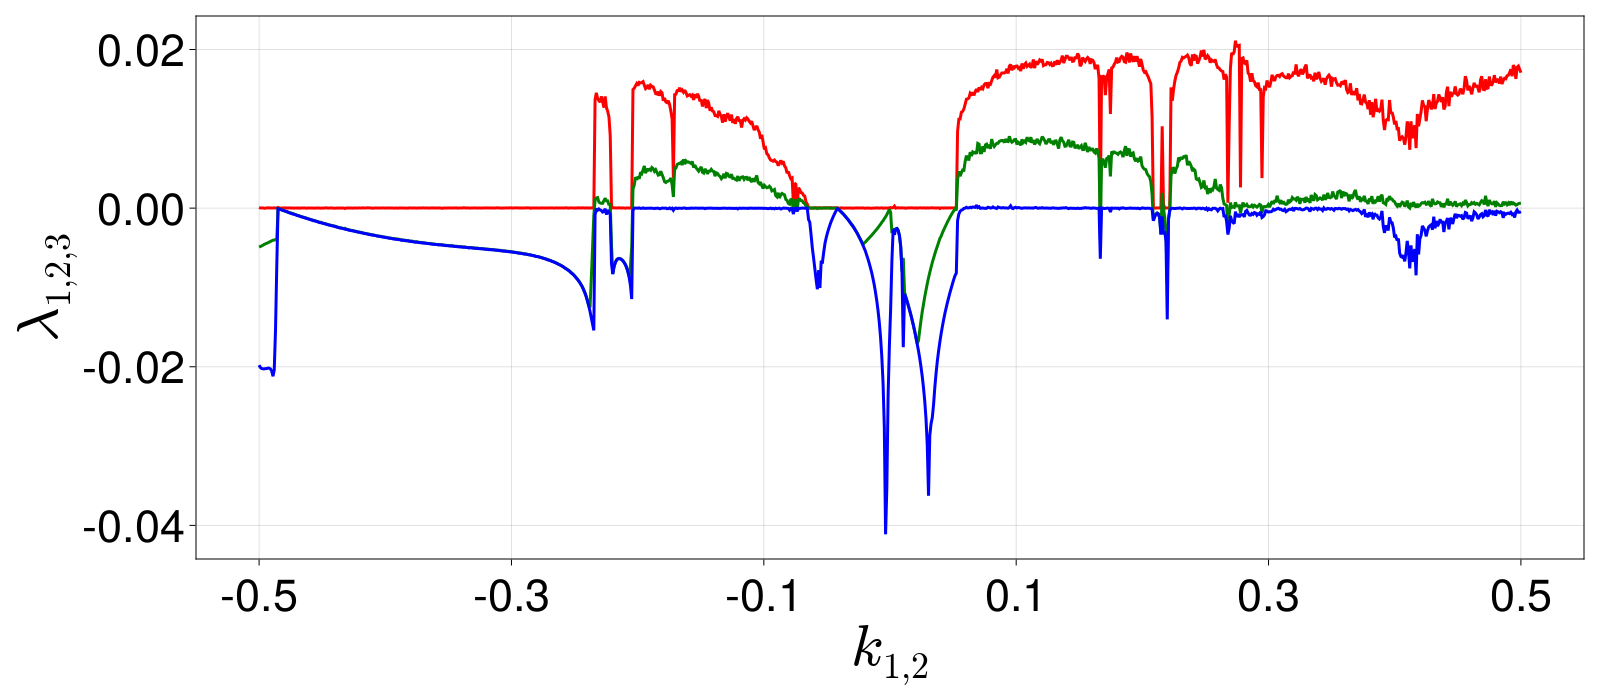

In [102]:
ticks = range(-0.5, 0.5, length = 6)
yticks = range(-0.04, 0.02, length = 4)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45, xticks = ticks, yticks = yticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.0, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.0, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.0, color = "blue")
save("LE_orbit_full.eps", f)
f

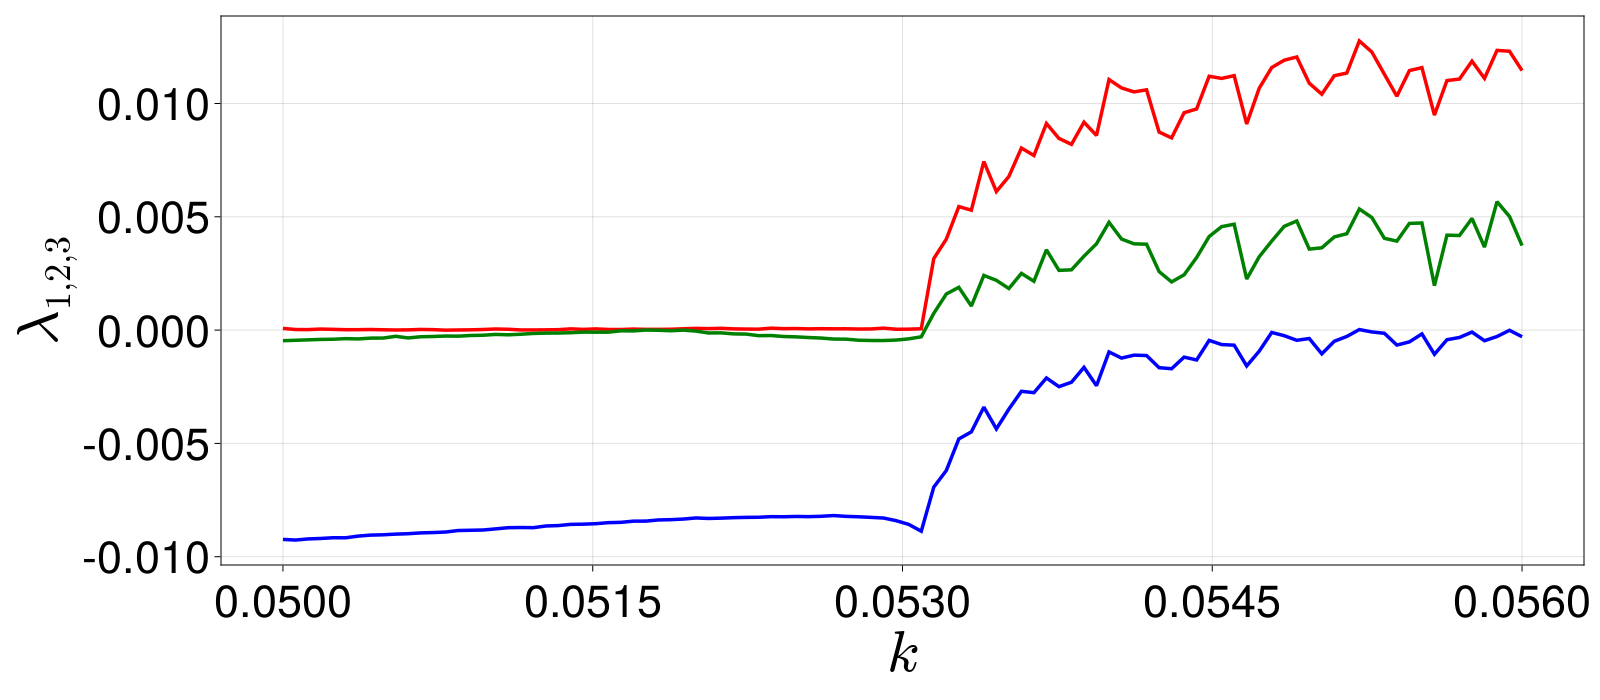

In [85]:
ticks = range(0.05, 0.056, length = 5)
f = Figure(resolution = (1600, 700), fontsize = 20)
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}",
xlabelsize = 60, ylabelsize = 60,
                xticklabelsize = 45, yticklabelsize = 45, xticks = ticks  )


lines!(ax, k_space, spectrum_array[1, :], linewidth = 3.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 3.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 3.5, color = "blue")
save("LE_orbit_zoom.eps", f)
f

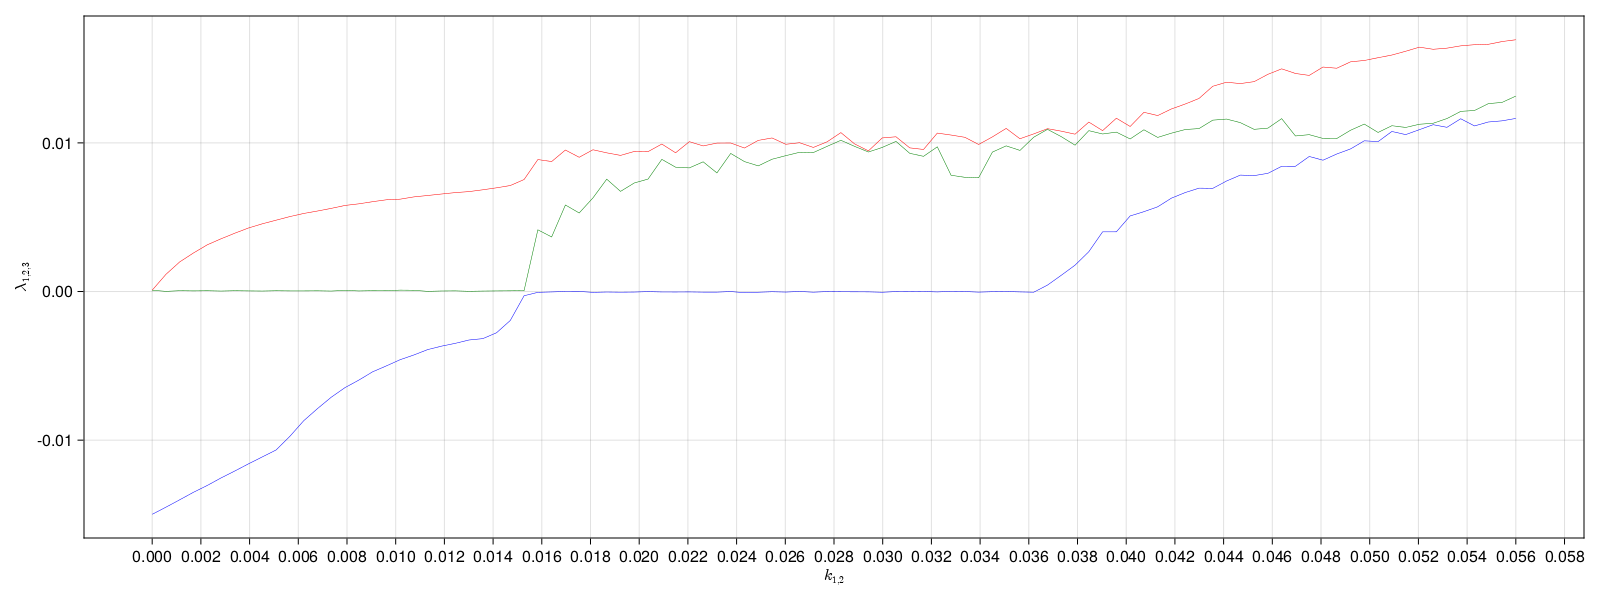

In [49]:
xticks = range(0.0, 0.56, step = 0.002)
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k_{1, 2}", ylabel = L"\lambda_{1, 2, 3}",
xticks = xticks)


lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f